# Purpose
The purpose of this notebook is to generate Figure 5.

# Preliminaries

## load packages

In [2]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import os
import glob
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors

#data
import random
from datetime import timedelta
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  
import networkx as nx
import community
from scipy.stats import spearmanr

#custom
from src import rfid 
from src import plot
from src import rfid 
from src import preprocess
from src import parameters as prms
from src import timestamps as tmp

Autosaving every 60 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## paths

In [3]:
# project root - to reproduce, just change root to the full path to wild-mus-vocal-ecology
root = '/path/to/wild-mus-vocal-ecology'

# paths to rfid reading directories (each contains a directory for meets, stays, and box events)
moth_rfid = os.path.join(root, 'data', 'rfid') # path to rfid data

# path to vocal events
vocal_events_path = os.path.join(root,'data', 'segments', 'vocal_events')

# path to vocal events
vocal_counts_path = os.path.join(root,'data', 'segments', 'vocal_counts')

# where mouse events are saved
mouse_events_root = os.path.join(moth_rfid, 'mouse_events')

# where mouse vocal events are saved
mouse_vocal_events_root = os.path.join(moth_rfid, 'mouse_vocal_events')

# path to adult phenotypes (with sex)
sexes_path = os.path.join(root, 'data', 'phenotypes', 'sexes.csv')

# path to data on litters born
pups_metadata_path = os.path.join(root, 'data', 'phenotypes', 'pups.csv')

# path to save the figures
path_to_save = ''

# audiomoth deployment dates
deployment_dates = os.path.join(root, 'parameters', 'json_files','deployment_dates.json')

# pups path
pups_discovered_path = os.path.join(root, 'parameters', 'pups_discovered_during_recording','pup_tracking.csv')

# path to 2 mice pic
two_mouse_pic_path = os.path.join(root, 'parameters', 'images','two_mice_1_square_crop.jpeg')


# Get transponder and sex data

In [4]:
# make a dictionary mapping transponder ID to sex
sexes = pd.read_csv(sexes_path, low_memory=False)
sex_dict = sexes.set_index('transponder_ID')['Sex'].to_dict()

# color them
sex_colors = {}
sex_colors['M'] = 'tomato'
sex_colors['F'] = 'skyblue'
sex_colors[float('NaN')] = 'grey'

# Get the raw data

In [1]:
# meets 2022-2023
print('getting meets...')
meets = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(moth_rfid, 'mouse_meets', '*.feather')) if int(os.path.basename(i)[:8]) >= 20220601])
meets = preprocess.raw_data_from_cloud_of_mice(meets, df_type='meets')

# stays 2022-2023
print('getting stays 2022-2023...')
stays = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(moth_rfid,  'mouse_stays', '*.feather')) if int(os.path.basename(i)[:8]) >= 20220601])
stays = stays.rename(columns={'box_number':'box'})
stays = preprocess.raw_data_from_cloud_of_mice(stays, df_type='stays')
stays = stays[stays['time_in_secs'] > 0] # drop the 4 stays with negative stay length

#occupancy 2022-2023
print('getting occupancy 2022-2023...')
box_events = pd.concat([pd.read_feather(i) for i in glob.glob(os.path.join(moth_rfid, 'box_events', '*.feather')) if int(os.path.basename(i)[:8]) >= 20220601])
box_events = preprocess.raw_data_from_cloud_of_mice(box_events, df_type='box_events')

#vocal events - all recordings
print('getting vocal events 2022-2023...')
v_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(vocal_events_path, '*segments.csv'))])
v_events = preprocess.raw_data_from_cloud_of_mice(v_events, df_type='vocal_events')

#vocal counts - all recordings
print('getting vocal counts 2022-2023...')
v_counts = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(vocal_counts_path, '*counts.csv'))])
v_counts = preprocess.raw_data_from_cloud_of_mice(v_counts, df_type='vocal_counts')

#mouse events
if os.path.exists(mouse_events_root) and len(os.listdir(mouse_events_root)) != 0:
    print('getting mouse events for audiomoth recorded boxes 2022-2023...')
    m_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(mouse_events_root, '*.csv'))])
    make_mouse_events = False
    
else:
    print("It looks like you didn't make any mouse events tables - you will make them below")
    make_mouse_events = True
    
#mouse vocal events
if os.path.exists(mouse_vocal_events_root) and len(os.listdir(mouse_vocal_events_root)) != 0:
    print('getting mouse-vocal by minute for audiomoth recorded boxes 2022-2023...')
    mv_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(mouse_vocal_events_root, '*.csv'))])
    make_mouse_vocal_events = False
else:
    print("It looks like you didn't make any mouse vocal events tables - you will make them below")
    make_mouse_vocal_events = True

print('Done.')

# Organize the raw data

In [2]:
# define audio dataset start and end
dataset_start = pd.to_datetime('2022-08-01 00:00:00')
dataset_end = pd.to_datetime('2023-12-02 23:59:59') 

#vocal events - all recordings
print('getting aligned vocal events 2022-2023...')
v_events_aligned = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(vocal_events_path, '*time-adjusted.csv'))])
v_events_aligned = preprocess.raw_data_from_cloud_of_mice(v_events_aligned, df_type='vocal_events')

#subset by start and end
stays = stays[(stays['entry_time'] >= dataset_start) & 
              (stays['exit_time'] <= dataset_end)]
meets = meets[(meets['overlap_start_time'] >= dataset_start) & 
              (meets['overlap_start_time'] <= dataset_end)]
box_events = box_events[(box_events['event_time'] >= dataset_start) & 
                        (box_events['event_time'] <= dataset_end)]
meets['sex_id1'] = meets['id1'].astype(int).map(sex_dict)
meets['sex_id2'] = meets['id2'].astype(int).map(sex_dict)

# minimum stay to consider for the purpose of this figure 
min_stay = 0.01

# add sex and stay time in minutes for convenience
stays['time_in_secs'] = stays['time_in_secs'].astype(float)
stays['time_in_minutes'] = stays['time_in_secs']/(60)
stays['sex'] = stays['transponder_id'].astype(int).map(sex_dict)

# these are the only boxes 2022-2023
stays = stays[stays['box'].isin(np.arange(2, 41, 2))] 
box_events = box_events[box_events['box'].isin(np.arange(2, 41, 2))]

### Make mouse events
- A datatable with one row per entrance/exit and information on the identity of occupants at that time
- Only make this for recorded boxes
- If you've already run this section, skip to "Make mouse-vocal events" below

In [7]:
#get every start and stop time for every recording that does not contain empty wav files
recordings_by_box = prms.load_json(os.path.join(root, 'parameters', 'json_files','recordings_by_box_20240618'))


In [8]:

if make_mouse_events:

    if not os.path.exists(mouse_events_root):
        os.mkdir(mouse_events_root)

    # get the deployments
    deployments = recordings_by_box.keys()

    #the names of the audiomoths
    audiomoths = ['audiomoth01', 'audiomoth02', 'audiomoth03', 'audiomoth04']

    # get the boxes recorded on each deployment
    boxes_recorded = prms.load_json(os.path.join(root, 'parameters', 'json_files','boxes_recorded.json'))

    for deployment in tqdm(deployments):

        boxes = recordings_by_box[deployment].keys()

        for box in boxes:
            # print(deployment, ':', box)
            path_to_save_csv = os.path.join(mouse_events_root, ('_').join([deployment, 'box'+str(box), 'mouse_events.csv']))
            
            if not os.path.exists(path_to_save_csv):

                #get the stays corresponding to this recording of this box
                recording_start = pd.to_datetime(recordings_by_box[deployment][str(box)][0])
                recording_end = pd.to_datetime(recordings_by_box[deployment][str(box)][1])

    #             print('\trecording_start:', recording_start)
    #             print('\trecording_end:', recording_end)
                these_stays = stays[(stays['box']==int(box)) & 
                                    (stays['entry_time'] <= recording_end) & 
                                    (stays['exit_time'] >= recording_start) ]
        

                #print('\tlen(these_stays):', len(these_stays))
                #if there are no stays, save an empty dataframe
                if len(these_stays) == 0:
                    mouse_events = pd.DataFrame(columns = ['event_time', 'event_type', 'id_triggering_event', 'occupant_count_following_event', 'occupant_ids_following_event', 'ids_in_network', 'box', 'deployment', 'audiomoth'])
                    mouse_events.to_csv(os.path.join(mouse_events_root, ('_').join([deployment, 'box'+str(box), 'mouse_events.csv'])), index=False)

                #get the entrances that occurred during the recording
                entrances = []
                event_type = []
                entrance_stay_durations = []
                ids = []
                for idx, row in these_stays.iterrows():

                    entrances.append(row['entry_time'])
                    ids.append(row['transponder_id'])
                    event_type.append('entrance')
                    entrance_stay_durations.append(row['time_in_secs'])
                    
                entrance_events = pd.DataFrame()
                entrance_events['event_time'] = entrances
                entrance_events['event_type'] = event_type
                entrance_events['id_triggering_event'] = ids
                entrance_events['event_stay_duration'] = entrance_stay_durations
                
                #get the exits
                exits = []
                event_type = []
                exit_stay_durations = []
                ids = []
                for idx, row in these_stays.iterrows():
                    exits.append(row['exit_time'])
                    ids.append(row['transponder_id'])
                    event_type.append('exit')
                    exit_stay_durations.append(row['time_in_secs'])

                exit_events = pd.DataFrame()
                exit_events['event_time'] = exits
                exit_events['event_type'] = event_type
                exit_events['id_triggering_event'] = ids
                exit_events['event_stay_duration'] = exit_stay_durations

                #combine them    
                mouse_events = pd.concat([entrance_events, exit_events])
                mouse_events = mouse_events.sort_values(by='event_time').reset_index(drop=True)

                #count the ids 
                all_occupants = []
                all_sexes = []
                current_occupants = []
                for idx, row in mouse_events.iterrows():

                    if row['event_type'] == 'entrance':
                        current_occupants.append(str(row['id_triggering_event']))

                    elif row['event_type'] == 'exit':
                        current_occupants.remove(str(row['id_triggering_event']))

                    all_sexes.append([sex_dict.get(float(i), 'NaN') for i in current_occupants])
                    all_occupants.append(current_occupants.copy())

                #add this information
                mouse_events['occupant_count_following_event'] = [len(i) for i in all_occupants]  
                mouse_events['occupant_ids_following_event'] = all_occupants  
                mouse_events['occupant_sexes_following_event'] = all_sexes
                mouse_events['male_count_following_event'] = [i.count('M') for i in all_sexes]
                mouse_events['female_count_following_event'] = [i.count('F') for i in all_sexes]
                mouse_events = mouse_events.reset_index(drop = True)
                mouse_events['sex_triggering_event'] = mouse_events['id_triggering_event'].astype(int).map(sex_dict)

                #add box and audiomoth info
                mouse_events['box'] = box
                mouse_events['deployment'] = deployment
                mouse_events['audiomoth'] = tmp.get_audiomoth_from_box(root, int(box),deployment)

                #save it
                mouse_events.to_csv(path_to_save_csv, index=False)
    print('done.')                                                                     

### Make mouse-vocal events
- A dataframe where each row corresponds to a 55s audiomoth recording window, and
- Columns describe the vocalizations and mice in the box during those 55s
- If you've already run this section, skip to "Make deployment metadata" below
- This will take about 45 minutes to run but will save csvs for each audiomoth deployment

In [9]:
#get every start and stop time for every recording that does not contain empty wav files
recordings_starts_stops = prms.load_json(os.path.join(root, 'parameters', 'json_files','recordings_by_box_20240618'))

In [10]:

if make_mouse_vocal_events:
    
    if not os.path.exists(mouse_vocal_events_root):
        os.mkdir(mouse_vocal_events_root)

    import ast
    mv_events = []

    # get the mouse events
    m_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(mouse_events_root, '*mouse_events.csv'))])

    # get the deployments
    deployments = recordings_by_box.keys()

    #convert to datetime
    v_events['audiomoth_start_seconds'] = pd.to_datetime(v_events['audiomoth_start_seconds'])
    v_events['audiomoth_stop_seconds'] = pd.to_datetime(v_events['audiomoth_stop_seconds'])
    m_events['event_time'] = pd.to_datetime(m_events['event_time'])
    
    for deployment in deployments: 
            print(deployment)

            v_moths = v_events['moth'][v_events['deployment'] == deployment].unique()
            m_moths = m_events['audiomoth'][m_events['deployment'] == deployment].unique()
            moths = [i for i in m_moths if i in v_moths if i != 'audiomoth00']

            for moth in moths:

                box = tmp.get_box_from_audiomoth(root, moth, deployment)
                path_to_save_csv = os.path.join(mouse_vocal_events_root, ('_').join([deployment, 'box'+str(box), 'mouse_vocal_events.csv']))
                if not os.path.exists(path_to_save_csv):

                    mouse_count_start_list = []
                    squeak_count_list = []
                    USV_count_list = []
                    num_males_start = []
                    num_females_start = []
                    moths_list = []
                    boxes_list = []
                    deployments_list = []

                    # get the recorded stays for this moth and deployment
                    these_stays_start = pd.to_datetime(recordings_starts_stops[deployment][str(box)][0])
                    these_stays_stop = pd.to_datetime(recordings_starts_stops[deployment][str(box)][1])
                    these_stays = stays[(stays['entry_time'] <= these_stays_stop) & 
                                        (stays['exit_time'] >= these_stays_start)]
                    
                    #get the vocal events for this moth and deployment
                    these_v_events = v_events[(v_events['deployment'] == deployment) & (v_events['moth'] == moth)].reset_index(drop = True)

                    #get the mouse events for this moth and deployment
                    these_m_events = m_events[(m_events['deployment'] == deployment) & (m_events['audiomoth'] == moth)].reset_index(drop = True)

                    #define the start and end of the audio recording
                    recording_start = pd.to_datetime(recordings_by_box[deployment][str(box)][0])
                    recording_end = pd.to_datetime(recordings_by_box[deployment][str(box)][1])

                    #make 1 min intervals between start and end
                    time_stamps = pd.date_range(start=recording_start, end=recording_end, freq='1T')

                    for time_stamp in tqdm(time_stamps): #for each time stamp

                        #get the 55s interval corresponding to audio recording time
                        start = time_stamp
                        end = time_stamp + timedelta(seconds = 55)

                        #subset vocal events to this interval (note we are operating only in rfid clock time)
                        interval_v_events = these_v_events[(these_v_events['audiomoth_start_seconds'] >= start) & (these_v_events['audiomoth_stop_seconds'] <= end)]

                        #get the moth
                        moths_list.append(moth)

                        #get the box
                        boxes_list.append(box)

                        #get the deployment
                        deployments_list.append(deployment)

                        #get the number of cries detected in the box in the interval
                        squeak_count_list.append((interval_v_events['label'] == 'squeak').sum())

                        #get the number of USVs detected in the box in the interval
                        USV_count_list.append((interval_v_events['label'] == 'USV').sum())

                        # get the ids of the mice in the box at the start of the 55s recording
                        occupants_start = rfid.get_occupants_at_time(timestamp=start, box=box, stays_df=these_stays)
                        sexes_start = [sex_dict.get(mouse) for mouse in occupants_start]
                        mouse_count_start_list.append(len(occupants_start))
                        num_males_start.append(len([i for i in sexes_start if i=='M']))
                        num_females_start.append(len([i for i in sexes_start if i=='F']))
                    
                        
                    # Save the data
                    these_mv_events = {
                            'time': time_stamps,
                            'deployment': deployments_list,
                            'box': boxes_list,
                            'moth': moths_list,
                            'squeak_count': squeak_count_list,
                            'USV_count': USV_count_list,
                            'mouse_count_start': mouse_count_start_list,
                            'male_count_start': num_males_start,
                            'female_count_start': num_females_start,
                        }

                    #make a dataframe
                    pd.DataFrame(these_mv_events).to_csv(path_to_save_csv, index=False)

    print('done.')


### Load the data in the csvs you just made

In [11]:
#mouse events
if make_mouse_vocal_events:

    if os.path.exists(mouse_events_root) and len(os.listdir(mouse_events_root)) != 0:
        print('getting mouse events for audiomoth recorded boxes 2022-2023...')
        m_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(mouse_events_root, '*.csv'))])
    else:
        print("It doesn't seem like you succesfully made the mouse_events files -- is the path correct?")
        
#mouse vocal events
if make_mouse_vocal_events:
    
    if os.path.exists(mouse_vocal_events_root) and len(os.listdir(mouse_vocal_events_root)) != 0:
        print('getting mouse-vocal by minute for audiomoth recorded boxes 2022-2023...')
        mv_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(mouse_vocal_events_root, '*.csv'))])
    else:
        print("It doesn't seem like you succesfully made the mouse_vocal_events files -- is the path correct?")

print('Done.')

Done.


### Calculate latencies between entances/exits and vocalizations
- Used in panels C-H

In [3]:
from src import timestamps

# prepare v_events
v_events_aligned['audiomoth_timestamp_datetime_adjusted'] = pd.to_datetime(v_events_aligned['audiomoth_timestamp_datetime_adjusted'])
v_events_aligned['audiomoth_start_seconds_adjusted'] = pd.to_datetime(v_events_aligned['audiomoth_start_seconds_adjusted'])
m_events['event_time'] = pd.to_datetime(m_events['event_time'])

# set the window
# this is the amount of time in seconds before and after each event (entrance or exit) to look for vocalizations
window_s=60

# set the random seed for timestamp randomization
random_seed = 654321

# entrance or exit
event_types = ['entrance','exit']
counts_df_list = []
latency_df_list = []

for event_type in event_types:
    for randomize in [True, False]:
        
        print(f'Event type is {event_type}')
        print(f'Randomize is {randomize}')

        # this function returns the count of vocalizations pre/post each event (entrance or exit) to counts_df
        # and the latency to each of those vocalizations relative to the event (entrance or exit) to latencies_df
        # when randomize is true, the same analysis is performed, but on timestamps randomly sampled 
        # from between the start and end of the recording, such that the number of timestamps sampled is equal
        # to the actual number of vocalizations, and sampling is done from a uniform distribution 
        latencies_df, counts_df = rfid.count_perievent_vocalizations(
            root=root,
            v_events=v_events_aligned,
            m_events=m_events,
            event_type=event_type,
            window_s=window_s,
            random_seed=random_seed,
            randomize=randomize
        )
        
        latency_df_list.append(latencies_df)
        counts_df_list.append(counts_df)

all_latencies = pd.concat(latency_df_list)
all_counts = pd.concat(counts_df_list)
print('done.')

In [13]:
# add season to actual (not shuffled) counts
all_actual_counts = all_counts[all_counts['randomized'] == False]
all_actual_counts['season'] = [rfid.get_season_from_date(i) for i in all_actual_counts['event_time']]

In [47]:
all_actual_counts['num_squeaks_in_interval'] = all_actual_counts['num_squeaks_in_interval_prior'] + all_actual_counts['num_squeaks_in_interval_post']
all_actual_counts['num_USVs_in_interval'] = all_actual_counts['num_USVs_in_interval_prior'] + all_actual_counts['num_USVs_in_interval_post']
all_actual_counts['num_vocs_in_interval'] = all_actual_counts['num_squeaks_in_interval'] + all_actual_counts['num_USVs_in_interval']

squeak_percentage = (len(all_actual_counts[all_actual_counts['num_squeaks_in_interval'] != 0]) / len(all_actual_counts)) * 100
print(f'{squeak_percentage:.2f}% of entrance/exit events contained at least one squeak in the interval')

USV_percentage = (len(all_actual_counts[all_actual_counts['num_USVs_in_interval'] != 0]) / len(all_actual_counts)) * 100
print(f'{USV_percentage:.2f}% of entrance/exit events contained at least one USV in the interval')

percentage = (len(all_actual_counts[all_actual_counts['num_vocs_in_interval'] != 0]) / len(all_actual_counts)) * 100
print(f'{percentage:.2f}% of entrance/exit events contained at least one voc of either type in the interval')



39.94% of entrance/exit events contained at least one squeak in the interval
12.24% of entrance/exit events contained at least one USV in the interval
42.16% of entrance/exit events contained at least one voc of either type in the interval


In [4]:
# count the vocalizations with latencies in bins of size bin_width, measured in seconds
# this data is used in panel 5C and D
df = all_latencies
bin_width = 1
entrance_latencies = df[(df['event_type'] == 'entrance') & (df['randomized'] == False)]
exit_latencies = df[(df['event_type'] == 'exit') & (df['randomized'] == False)]

entrance_latencies_binned = rfid.bin_vocal_latencies(latency_df = entrance_latencies, 
                                          bin_width = bin_width, 
                                          groupby = 'mouse_triggering_event')

exit_latencies_binned = rfid.bin_vocal_latencies(latency_df = exit_latencies, 
                                          bin_width = bin_width, 
                                      groupby = 'mouse_triggering_event')

#transpose and normalize for heatmaps
#entrance latencies (pancel C)
entrance_latencies_binned_transposed = entrance_latencies_binned.T
normalized_entrance_latencies_df = entrance_latencies_binned_transposed.div(entrance_latencies_binned_transposed.max(axis=1), axis=0).fillna(0)
normalized_entrance_latencies_df['Sex'] = normalized_entrance_latencies_df.index.map(sex_dict)
normalized_entrance_latencies_df = normalized_entrance_latencies_df.sort_values('Sex')
normalized_entrance_latencies_df = normalized_entrance_latencies_df.drop(columns = 'Sex')

#exit latencies (panel D)
exit_latencies_binned_transposed = exit_latencies_binned.T
normalized_exit_latencies_df =  exit_latencies_binned_transposed.div(exit_latencies_binned_transposed.max(axis=1), axis=0).fillna(0)
normalized_exit_latencies_df['Sex'] = normalized_exit_latencies_df.index.map(sex_dict)
normalized_exit_latencies_df = normalized_exit_latencies_df.sort_values('Sex')
normalized_exit_latencies_df = normalized_exit_latencies_df.drop(columns = 'Sex')

#test plot
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 10))

#heatmap
sns.heatmap(normalized_entrance_latencies_df, 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Count'}, 
            annot=False, ax=ax1)
ax1.set_xlabel('Time Bins')
ax1.set_ylabel('Entrance Events')
ax1.set_title('Heatmap of Latencies for Each Entrance Event (Raw Counts)')
ax1.axvline(x = 60, color = 'black', linestyle = '--', linewidth = 0.5)

# Heatmap
sns.heatmap(normalized_exit_latencies_df, 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Count'}, 
            annot=False, ax=ax2)
ax2.set_xlabel('Time Bins')
ax2.set_ylabel('Entrance Events')
ax2.set_title('Heatmap of Latencies for Each Exit Event (Raw Counts)')
ax2.axvline(x = 60, color = 'black', linestyle = '--', linewidth = 0.5)

### Make deployment metadata
- Used in panels A, B, and supplemental table 1

In [15]:
# make the dataframe
squeak_counts = v_counts.groupby(['season' , 'deployment','moth', 'box'])['squeak_count'].sum().reset_index()
USV_counts = v_counts.groupby(['season' , 'deployment','moth', 'box'])['USV_count'].sum().reset_index()
counts = squeak_counts.merge(USV_counts, on = ['season' , 'deployment','moth', 'box'])
contains_squeaks = v_counts.groupby(['season' , 'deployment','moth', 'box'])['squeak_count'].apply(lambda x: (x > 0).mean() * 100).reset_index().rename(columns={'squeak_count':'percent_minutes_squeak'})
contains_USVs = v_counts.groupby(['season', 'deployment','moth', 'box'])['USV_count'].apply(lambda x: (x > 0).mean() * 100).reset_index().rename(columns={'USV_count':'percent_minutes_USV'})
contains = contains_squeaks.merge(contains_USVs, on = ['season', 'deployment','moth', 'box'])
deployment_metadata = counts.merge(contains, on = ['season', 'deployment','moth', 'box'])

# useful quick functions to get time of recording start and stop
def get_recording_start(row):
    try:
        return recordings_starts_stops[row['deployment']][str(row['box'])][0]
    except KeyError:
        return None  # or handle missing keys appropriately

def get_recording_stop(row):
    try:
        return recordings_starts_stops[row['deployment']][str(row['box'])][1]
    except KeyError:
        return None  # or handle missing keys appropriately

deployment_metadata['recording_start'] = deployment_metadata.apply(get_recording_start, axis=1)
deployment_metadata['recording_stop'] = deployment_metadata.apply(get_recording_stop, axis=1)
deployment_metadata['recording_start'] = pd.to_datetime(deployment_metadata['recording_start'])
deployment_metadata['recording_stop'] = pd.to_datetime(deployment_metadata['recording_stop'])

# now add columns about mouse identity
stays['entry_time'] = pd.to_datetime(stays['entry_time'])
stays['exit_time'] = pd.to_datetime(stays['exit_time'])
meets['overlap_start_time'] = pd.to_datetime(meets['overlap_start_time'])
meets['overlap_end_time'] = pd.to_datetime(meets['overlap_end_time'])

# now add the rest of the columns using the get_recorded_box_metadata function in the rfid module
# define the columns to add
metadata_columns = [
    'mice',
    'sexes',
    'total_mice',
    'total_males',
    'total_females',
    'sex_ratio'
]

deployment_metadata[metadata_columns] = deployment_metadata.progress_apply(lambda row: rfid.get_recorded_box_metadata(row, 
                                                                                                                      stays_df=stays, 
                                                                                                                      meets_df=meets, 
                                                                                                                      sex_dict=sex_dict), 
                                                                           axis=1
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:01<00:00, 126.77it/s]


# AIC Model selection

In [16]:
# import extra packages needed
from src import modelselection
from scipy.stats import shapiro
from scipy.stats import boxcox

## add pups discovered during recording to mv_events

In [17]:
# add pup counts to mv_events
# these are pups counts that were made at the time each audiomoth was placed on a box or removed from it
pups_by_deployment = pd.read_csv(pups_discovered_path)

# season dictionary bc this will be useful
season_name_dict = {1: 'winter', 2:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 7:'summer', 8:'summer', 9:'autumn', 10:'autumn', 11:'autumn', 12:'winter'}

#make sure the deployments match, then merge, add useful columns, and make sure they are the right data type
pups_by_deployment = pups_by_deployment[pups_by_deployment['deployment'].isin(mv_events['deployment'].unique())]
deployment_metadata_pups = pd.merge(deployment_metadata, pups_by_deployment, on = ['moth', 'deployment'], 
                                    how = 'left')
deployment_metadata_pups['month'] = deployment_metadata_pups['recording_start'].dt.month
deployment_metadata_pups = deployment_metadata_pups.rename(columns = {'season':'season_with_year'})
deployment_metadata_pups['season'] = deployment_metadata_pups['month'].map(season_name_dict)
deployment_metadata_pups['season'] = deployment_metadata_pups['season'].astype('category')
deployment_metadata_pups['box'] = deployment_metadata_pups['season'].astype('category')


## check for over dispersion

count data should be overdispersed

In [18]:
squeak_count_mean, squeak_count_var = deployment_metadata_pups['squeak_count'].mean(), deployment_metadata_pups['squeak_count'].var()
USV_count_mean, USV_count_var = deployment_metadata_pups['USV_count'].mean(), deployment_metadata_pups['USV_count'].var()

if squeak_count_var > squeak_count_mean:
    print('squeak count variance is', squeak_count_var/squeak_count_mean, 'times greater than mean.') 
else:
    print('squeak count variance is not greater than mean.')
    
if USV_count_var > USV_count_mean:
    print('USV count variance is', USV_count_var/squeak_count_mean, 'times greater than mean.') 
else:
    print('USV count variance is not greater than mean.')

squeak count variance is 68728.39013530996 times greater than mean.
USV count variance is 560.5914508476408 times greater than mean.


In [19]:
# define response variable
response_vars = ['USV_count', 'squeak_count']
predictors = ['total_mice', 
              'sex_ratio', 
              'season', 
              'pups_count_pickup']

# this function will return a list of tuples, one for each model
# whether the first item in each tuple is the full model and the second is the response variable
list_of_models = modelselection.generate_model_list(predictors, response_vars)
list_of_models

[('USV_count ~ season*total_mice', 'USV_count'),
 ('USV_count ~ season*sex_ratio', 'USV_count'),
 ('USV_count ~ season', 'USV_count'),
 ('USV_count ~ season*pups_count_pickup', 'USV_count'),
 ('squeak_count ~ season*total_mice', 'squeak_count'),
 ('squeak_count ~ season*sex_ratio', 'squeak_count'),
 ('squeak_count ~ season', 'squeak_count'),
 ('squeak_count ~ season*pups_count_pickup', 'squeak_count')]

## fit models

In [14]:
model_evaluation, models = modelselection.fit_glm_nb_models(df = deployment_metadata_pups, models = list_of_models) 

In [21]:
nice_table = model_evaluation.sort_values(by = ['Response','AIC']).reset_index(drop = True).drop(columns = ['BIC', 'Converged'])
nice_table

,Model,Response,AIC,Pseudo R-squared
0,USV_count ~ season*pups_count_pickup,USV_count,1632.402856,0.1513
1,USV_count ~ season,USV_count,1707.200428,0.1681
2,USV_count ~ season*sex_ratio,USV_count,1868.671548,0.2976
3,USV_count ~ season*total_mice,USV_count,1873.766526,0.2661
4,squeak_count ~ season*pups_count_pickup,squeak_count,2486.975552,0.7879
5,squeak_count ~ season*total_mice,squeak_count,2659.778851,0.5381
6,squeak_count ~ season,squeak_count,2661.180518,0.4899
7,squeak_count ~ season*sex_ratio,squeak_count,2665.581140,0.5079


## choose models based on AIC

In [22]:
modelselection.best_model_assessment(df_results = model_evaluation, criterion = 'AIC')

Best model for USV_count:
Model: USV_count ~ season*pups_count_pickup
AIC: 1632.4028556464593
BIC: 1651.677986984204
pseudo-R-squared: 0.1513

Best model for squeak_count:
Model: squeak_count ~ season*pups_count_pickup
AIC: 2486.9755523310578
BIC: 2507.5168698629727
pseudo-R-squared: 0.7879



# Make the Figure

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19261/1675171674.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes["B"].set_xticklabels(new_labels)
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19261/1675171674.py:227: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data = df_grouped,
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19261/1675171674.py:290: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data = df_grouped,
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19261/1675171674.py:358: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:

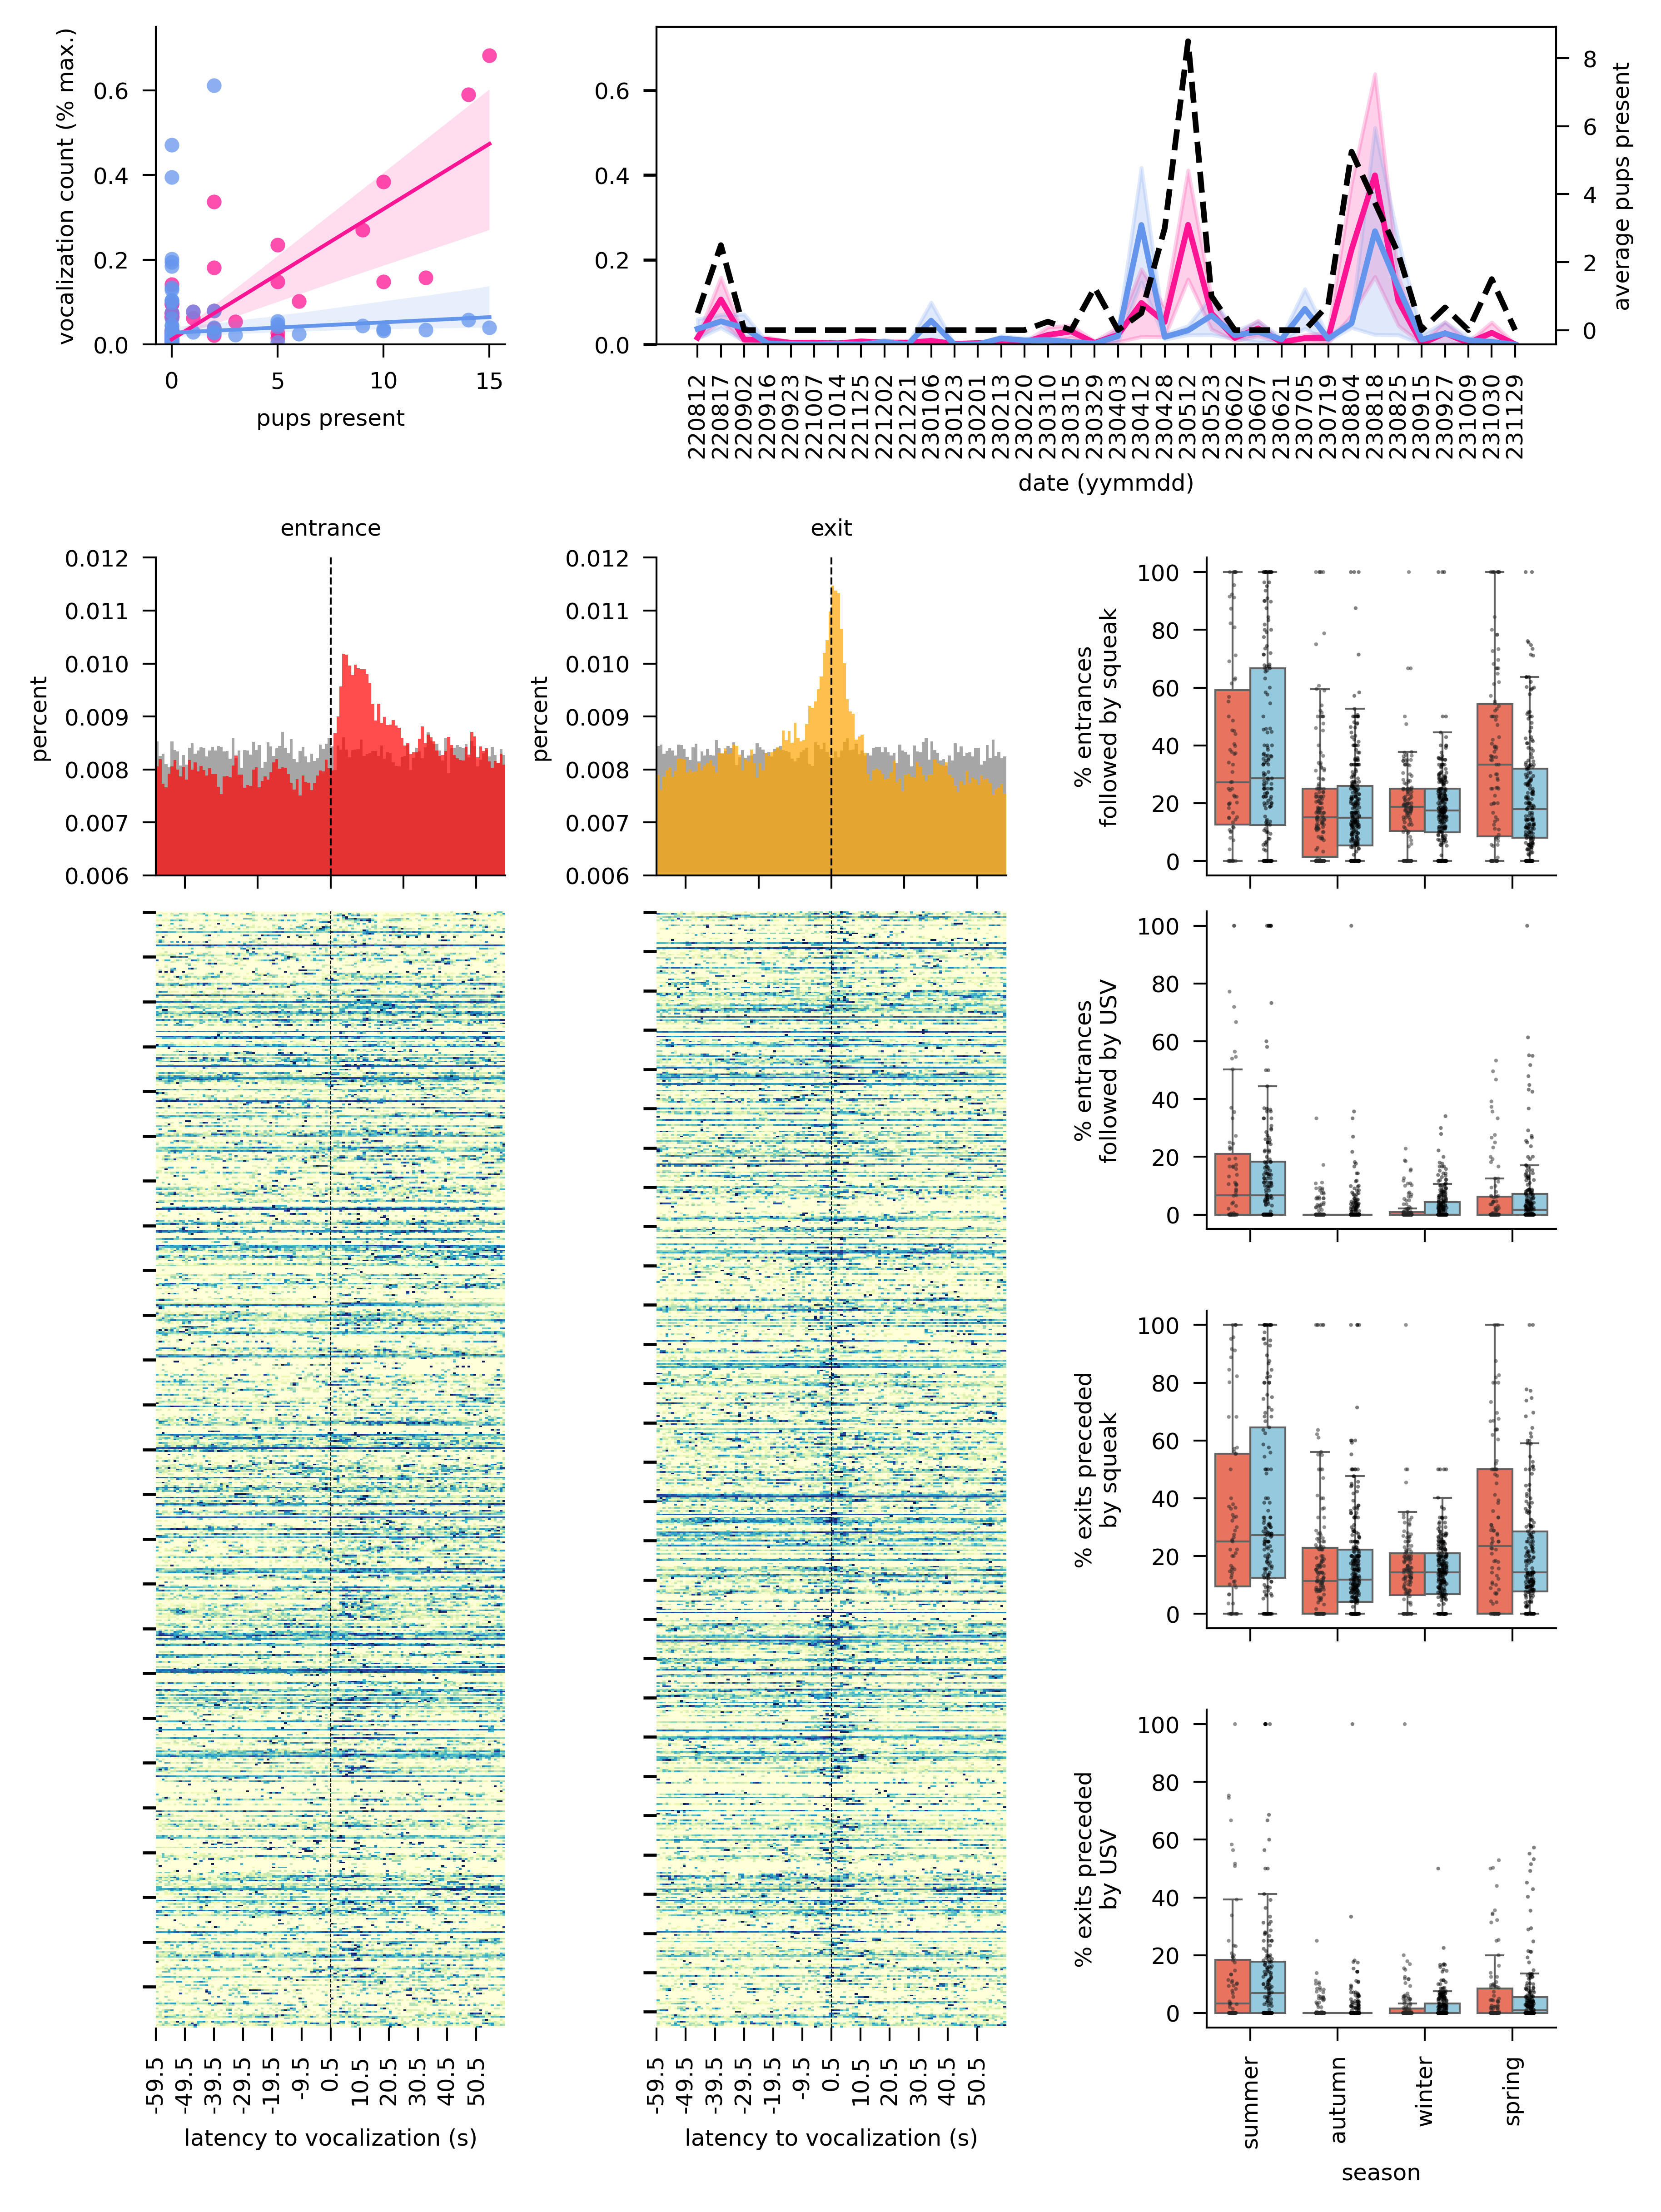

In [23]:
# save or not
save = False
path_to_save = ''

##################################################################################################

fig, axes = plt.subplot_mosaic(mosaic=".AABBBB.;"\
                                      ".CCDDEE.;"\
                                      ".HHIIFF.;"\
                                      ".HHIIJJ.;"\
                                      ".HHIIKK.",

                               figsize=[8.5,8], 
                               
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.5,0.5,0.5, 0.5, 0.5],
                                           "width_ratios": [1, 0.25,0.25,0.25, 0.25, 0.25,0.25, 1]},
                               dpi=600)

#plot parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 10 # for panel F x-axis
dot_size = .5
dot_alpha = .75
spine_width = 0.5
meeting_type_order = ['MM', 'MF', 'FF']
meeting_type_palette = {'FF':'skyblue', 'MF':'lightgrey', 'MM':'tomato'}
season_order = ['summer', 'autumn', 'winter', 'spring']
sex_palette = {'M':'tomato', 'F':'skyblue'}
deployment_metadata_pups = deployment_metadata_pups.sort_values(by = ['deployment'])

##################################################################################################
# panel A - squeak vs pups correlation
##################################################################################################
data = deployment_metadata_pups.sort_values(by = 'deployment')
data['normalized_squeak_count'] = data['squeak_count']/np.max(data['squeak_count'])
data['normalized_USV_count'] = data['USV_count']/np.max(data['USV_count'])
data['normalized_pups_count_pickup'] = data['pups_count_pickup']/np.max(data['pups_count_pickup'])

sns.regplot(data = data, 
             x = 'pups_count_pickup', 
             y = 'normalized_squeak_count', 
             ax = axes["A"], 
             scatter = False, 
            line_kws={"linewidth": 1, "color": "deeppink"})
sns.scatterplot(data = data, 
             x = 'pups_count_pickup', 
             y = 'normalized_squeak_count', 
             linewidth = 0, 
                color = 'deeppink',
             ax = axes["A"], 
             s = dot_size + 14.5, 
            alpha = dot_alpha,
             legend = False)
sns.regplot(data = data, 
             x = 'pups_count_pickup', 
             y = 'normalized_USV_count', 
             ax = axes["A"], 
             scatter = False, 
            line_kws={"linewidth": 1, "color": "cornflowerblue"})
sns.scatterplot(data = data, 
             x = 'pups_count_pickup', 
             y = 'normalized_USV_count', 
             linewidth = 0, 
                color = 'cornflowerblue',
             ax = axes["A"], 
             s = dot_size + 14.5, 
            alpha = dot_alpha,
             legend = False)

axes["A"].tick_params(axis='y', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["A"].tick_params(axis='x', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["A"].set_ylabel('vocalization count (% max.)', color='black', fontsize = tick_label_fontsize)
axes["A"].set_xlabel('pups present', color='black', fontsize = tick_label_fontsize)
axes["A"].set_ylim([0,0.75])
sns.despine(ax = axes["A"])

##################################################################################################
# panel B - squeaks and pups by time
##################################################################################################

# Plot percent_minutes_squeak on the primary y-axis
sns.lineplot(data=data, 
             ax = axes["B"], x='deployment', 
             y='normalized_squeak_count', 
             color='deeppink', 
             errorbar = 'se')
sns.lineplot(data=data, 
             ax = axes["B"], 
             x='deployment', 
             y='normalized_USV_count', 
             color='cornflowerblue', 
             errorbar = 'se')

#axes["B"].set_ylabel('average vocalization count (% max)', color='black', fontsize = tick_label_fontsize)
axes["B"].set_ylabel('')
axes["B"].set_xlabel('date (yymmdd)', color='black', fontsize = tick_label_fontsize)
axes["B"].tick_params(axis='y', labelcolor='black', labelsize = tick_label_fontsize)
axes["B"].tick_params(axis='x', labelcolor='black', labelsize = tick_label_fontsize, rotation = 90, width = spine_width)

new_labels = [tick.get_text().split('-')[0][2:] for tick in axes["B"].get_xticklabels()]
axes["B"].set_xticklabels(new_labels)
axes["B"].set_ylim([0,0.75])

# Create secondary y-axis and plot pups_count_pickup
axB = axes["B"].twinx()
sns.lineplot(data=data, x='deployment', y='pups_count_pickup', ax=axB, color='black', errorbar = None, linestyle = '--')
axB.set_ylabel('average pups present', color='black', fontsize = tick_label_fontsize)
axB.tick_params(axis='y', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
sns.despine(ax = axes["B"])

for ax in ["A", "B", "C", "D", "E", "F", "J", "K"]:
    for spine in axes[ax].spines.values():
        spine.set_linewidth(spine_width)  # Set the width to a smaller value
for spine in axB.spines.values():
        spine.set_linewidth(spine_width)  # Set the width to a smaller value
        
##################################################################################################
# panel C - histogram of vocalizations relative to entrance
##################################################################################################

df = all_latencies
binwidth = 1
alpha = 0.7
sns.histplot(data = df[(df['event_type'] == 'entrance') & (df['randomized'] == True)], 
             x = 'latency_to_voc',
             linewidth = 0, 
             color = 'grey', 
             alpha = alpha, 
             binwidth = binwidth, 
             stat = "probability",
             ax = axes["C"])
sns.histplot(data = df[(df['event_type'] == 'entrance') & (df['randomized'] == False)], 
             x = 'latency_to_voc', 
             linewidth = 0, 
             color = 'red', 
             alpha = alpha, 
             binwidth = binwidth, 
             stat = "probability",
             ax = axes["C"])

for_x_lim = df[df['randomized'] == False]
min_val = for_x_lim[for_x_lim['event_type'] == 'entrance']['latency_to_voc'].min()
max_val = for_x_lim[for_x_lim['event_type'] == 'entrance']['latency_to_voc'].max()
axes["C"].set_xlim(min_val, max_val)
axes["C"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["C"].axvline(x = 0, color = 'black', linewidth = 0.5, linestyle = '--')
axes["C"].set_title('entrance', fontsize = tick_label_fontsize)
axes["C"].set_ylabel('percent', fontsize = tick_label_fontsize)
#axes["C"].set_xlabel('latency to vocalization (s)', fontsize = tick_label_fontsize)
axes["C"].set_xlabel('')
axes["C"].set_xticklabels([])
axes["C"].set_ylim([0.006,0.012])
sns.despine(ax = axes["C"])

##################################################################################################
# panel D - histogram of vocalizations relative to exit
##################################################################################################

sns.histplot(data = df[(df['event_type'] == 'exit') & (df['randomized'] == True)], 
             x = 'latency_to_voc',
             linewidth = 0, 
             color = 'grey', 
             alpha = alpha, 
             binwidth = binwidth, 
             stat = "probability",
             ax = axes["D"])
sns.histplot(data = df[(df['event_type'] == 'exit') & (df['randomized'] == False)], 
             x = 'latency_to_voc', 
             linewidth = 0, 
             color = 'orange', 
             alpha = alpha, 
             binwidth = binwidth, 
             stat = "probability",
             ax = axes["D"])
for_x_lim = df[df['randomized'] == False]
min_val = for_x_lim[for_x_lim['event_type'] == 'exit']['latency_to_voc'].min()
max_val = for_x_lim[for_x_lim['event_type'] == 'exit']['latency_to_voc'].max()
axes["D"].set_xlim(min_val, max_val)
axes["D"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["D"].axvline(x = 0, color = 'black', linewidth = 0.5, linestyle = '--')
axes["D"].set_title('exit', fontsize = tick_label_fontsize)
axes["D"].set_ylabel('')
axes["D"].set_ylabel('percent', fontsize = tick_label_fontsize)
#axes["D"].set_xlabel('latency to vocalization (s)', fontsize = tick_label_fontsize)
axes["D"].set_xlabel('')
axes["D"].set_xticklabels([])
axes["D"].set_ylim([0.006,0.012])
sns.despine(ax = axes["D"])


##################################################################################################
# panel E - box plot of latencies to first squeak from entrance by sex and season
##################################################################################################

# get the data to plot
event_type = 'entrance'
df = all_actual_counts.copy()
event_type = 'entrance' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['squeak_occurred'] = df['num_squeaks_in_interval_post'] > 0

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
df_grouped = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('squeak_occurred', 'size'),
    with_squeaks=('squeak_occurred', 'sum')
).reset_index()
df_grouped['percent_with_squeaks'] = (df_grouped['with_squeaks'] / df_grouped['total_events'] * 100)

sns.boxplot(data = df_grouped, 
             y = 'percent_with_squeaks', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            order = ['summer', 'autumn', 'winter', 'spring'],
            showfliers = False, 
            linewidth = 0.5,
            ax = axes["E"], 
            palette = sex_palette, 
            hue_order = ['M', 'F'])

sns.stripplot(data = df_grouped, 
             y = 'percent_with_squeaks', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            dodge = True,
            order = ['summer', 'autumn', 'winter', 'spring'],
            linewidth = 0, 
              s = 1, alpha = 0.5,
            ax = axes["E"], 
            color = 'black', 
            hue_order = ['M', 'F'])

axes["E"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["E"].set_ylabel('% entrances\nfollowed by squeak', fontsize = tick_label_fontsize)
axes["E"].set_xlabel('season', fontsize = tick_label_fontsize)
sns.despine(ax = axes["E"])

##################################################################################################
# panel F - box plot of latencies to first USV from entrance by sex and season
##################################################################################################

# df = all_latencies.copy()
# df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
# df['sex_triggering_event'] = df['mouse_triggering_event'].map(sex_dict)
# df = df[(df['randomized']==False)]
# df = df[df['label'] == label]
# df = df[df['event_type'] == event_type] 
# df = df[df['latency_to_voc'] > 0] # only look at vocalizations following entrance, ie with positive latency
# groupby_columns = ['yearless_season', 'mouse_triggering_event']
# other_columns = ['deployment', 'moth', 'box', 'event_type','sex_triggering_event', y_value]
# df_grouped = df[groupby_columns+other_columns].groupby(groupby_columns).agg({y_value: 'mean', 
#                                                                              'event_type':'first', # event type is the same bc of filtering above
#                                                                              'sex_triggering_event':'first' # sex is the same for every ID
#                                                                             }).reset_index()

# get the data to plot
df = all_actual_counts.copy()
event_type = 'entrance' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['USV_occurred'] = df['num_USVs_in_interval_post'] > 0

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
df_grouped = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('USV_occurred', 'size'),
    with_USV=('USV_occurred', 'sum')
).reset_index()
df_grouped['percent_with_USV'] = (df_grouped['with_USV'] / df_grouped['total_events'] * 100)

sns.boxplot(data = df_grouped, 
             y = 'percent_with_USV', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            order = season_order,
            showfliers = False, 
            linewidth = 0.5,
            ax = axes["F"], 
            palette = sex_palette, 
            hue_order = ['M', 'F'])

sns.stripplot(data = df_grouped, 
             y = 'percent_with_USV', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            dodge = True,
            order = season_order,
            linewidth = 0, 
              s = 1, alpha = 0.5,
            ax = axes["F"], 
            color = 'black', 
            hue_order = ['M', 'F'])

axes["F"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["F"].set_ylabel('% entrances\nfollowed by USV', fontsize = tick_label_fontsize)
axes["F"].set_xlabel('season', fontsize = tick_label_fontsize)
sns.despine(ax = axes["F"])

######################################################################################
# panel J - box plot of latencies to first squeak from entrance by sex and season
######################################################################################

# get the data to plot
event_type = 'exit'
df = all_actual_counts.copy()
event_type = 'entrance' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['squeak_occurred'] = df['num_squeaks_in_interval_prior'] > 0 # note that this says prior, not post!

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
df_grouped = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('squeak_occurred', 'size'),
    with_squeaks=('squeak_occurred', 'sum')
).reset_index()
df_grouped['percent_with_squeaks'] = (df_grouped['with_squeaks'] / df_grouped['total_events'] * 100)


sns.boxplot(data = df_grouped, 
             y = 'percent_with_squeaks', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            order = season_order,
            showfliers = False, 
            linewidth = 0.5,
            ax = axes["J"], 
            palette = sex_palette, 
            hue_order = ['M', 'F'])

sns.stripplot(data = df_grouped, 
             y = 'percent_with_squeaks', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            dodge = True,
            order = season_order,
            linewidth = 0, 
              s = 1, alpha = 0.5,
            ax = axes["J"], 
            color = 'black', 
            hue_order = ['M', 'F'])


axes["J"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["J"].set_ylabel('% exits preceded\nby squeak', fontsize = tick_label_fontsize)
axes["J"].set_xlabel('season', fontsize = tick_label_fontsize)
sns.despine(ax = axes["J"])


##################################################################################################
# panel K - box plot of latencies to first USV from entrance by sex and season
##################################################################################################


# get the data to plot
df = all_actual_counts.copy()
event_type = 'exit' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['USV_occurred'] = df['num_USVs_in_interval_prior'] > 0 

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
df_grouped = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('USV_occurred', 'size'),
    with_USV=('USV_occurred', 'sum')
).reset_index()
df_grouped['percent_with_USV'] = (df_grouped['with_USV'] / df_grouped['total_events'] * 100)


sns.boxplot(data = df_grouped, 
             y = 'percent_with_USV', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            order = season_order,
            showfliers = False, 
            linewidth = 0.5,
            ax = axes["K"], 
            palette = sex_palette, 
            hue_order = ['M', 'F'])

sns.stripplot(data = df_grouped, 
             y = 'percent_with_USV', 
            x = 'yearless_season', 
            hue = 'sex_triggering_event', 
            dodge = True,
            order = season_order,
            linewidth = 0, 
              s = 1, alpha = 0.5,
            ax = axes["K"], 
            color = 'black', 
            hue_order = ['M', 'F'])

axes["K"].tick_params(axis='both', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)
axes["K"].tick_params(axis='x', rotation = 90)
axes["K"].set_ylabel('% exits preceded\nby USV', fontsize = tick_label_fontsize)
axes["K"].set_xlabel('season', fontsize = tick_label_fontsize)
sns.despine(ax = axes["K"])

for ax in ["E", "F", "J", "K"]:
    
    axes[ax].legend_.remove()


##################################################################################################
# panel H - heatmap of vocalizations relative to entrance
##################################################################################################

# Heatmap
sns.heatmap(normalized_entrance_latencies_df, 
            cmap='YlGnBu', 
            cbar = False, 
            annot=False, 
            ax=axes["H"])

axes["H"].axvline(x = 60, color = 'black', linestyle = '--', linewidth = 0.25)
axes["H"].set_yticklabels([])
axes["H"].set_xlabel('latency to vocalization (s)', fontsize = tick_label_fontsize)
axes["H"].tick_params(axis='x', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)

entrance_columns = normalized_entrance_latencies_df.columns
entrance_tick_indices = list(range(0, len(entrance_columns), 10))
entrance_tick_labels = [entrance_columns[i] for i in entrance_tick_indices]


axes["H"].set_xticks(entrance_tick_indices)
axes["H"].set_xticklabels(entrance_tick_labels, rotation=90)

##################################################################################################
# panel I - heatmap of vocalizations relative to exits
##################################################################################################

# Heatmap
sns.heatmap(normalized_exit_latencies_df, 
            cmap='YlGnBu', 
            cbar = False, 
            annot=False, 
            ax=axes["I"])

axes["I"].axvline(x = 60, color = 'black', linestyle = '--', linewidth = 0.25)
axes["I"].set_yticklabels([])
axes["I"].set_xlabel('latency to vocalization (s)', fontsize = tick_label_fontsize)
axes["I"].tick_params(axis='x', labelcolor='black', labelsize = tick_label_fontsize, width = spine_width)

exit_columns = normalized_exit_latencies_df.columns
exit_tick_indices = list(range(0, len(exit_columns), 10))
exit_tick_labels = [exit_columns[i] for i in exit_tick_indices]

axes["I"].set_xticks(exit_tick_indices)
axes["I"].set_xticklabels(exit_tick_labels, rotation=90)

for ax in ["E", "J", "F"]:
    axes[ax].set_xlabel('')
    axes[ax].set_xticklabels([])


if save:
    plt.savefig(os.path.join(path_to_save, 'Figure5.jpeg'), dpi = 600)
    plt.savefig(os.path.join(path_to_save, 'Figure5.svg'), dpi = 600)
    

# Statistics

In [48]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi
import statsmodels.stats.multitest as smm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from docx import Document
from docx.shared import Inches
from src import modelselection
import scipy.stats as stats

In [54]:
statistics_dir = ''
save = False # if true, save statistics csvs and output to statistics_dir

### Save the pretty AIC Table (Supplemental Table 1)

In [50]:
nice_table = model_evaluation.sort_values(by = ['Response','AIC']).reset_index(drop = True).drop(columns = ['BIC', 'Converged'])
nice_table

,Model,Response,AIC,Pseudo R-squared
0,USV_count ~ season*pups_count_pickup,USV_count,1632.402855,0.1513
1,USV_count ~ season,USV_count,1707.200431,0.1681
2,USV_count ~ season*sex_ratio,USV_count,1868.671548,0.2976
3,USV_count ~ season*total_mice,USV_count,1873.766527,0.2660
4,squeak_count ~ season*pups_count_pickup,squeak_count,2486.975506,0.7877
5,squeak_count ~ season*total_mice,squeak_count,2659.778843,0.5380
6,squeak_count ~ season,squeak_count,2661.180488,0.4901
7,squeak_count ~ season*sex_ratio,squeak_count,2665.580494,0.5087


In [51]:
analysis_name = 'figure5_supplementaltable1'
anova_table = pd.DataFrame()
tukey_result = nice_table

if save:
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))

### Panel E 
% entrances followed by squeak ~ (sex) * (season)

In [5]:
# get the data to plot
event_type = 'entrance'
df = all_actual_counts.copy()
event_type = 'entrance' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['squeak_occurred'] = df['num_squeaks_in_interval_post'] > 0

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
data = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('squeak_occurred', 'size'),
    with_squeaks=('squeak_occurred', 'sum')
).reset_index()
data['percent_with_squeaks'] = (data['with_squeaks'] / data['total_events'] * 100)

analysis_name = 'figure5_panelE'
dependent_var = 'percent_with_squeaks'

# Fit the linear model with interaction between sex and season
formula = dependent_var +' ~ sex_triggering_event*yearless_season'
model = smf.ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['yearless_season'].astype(str) + '-' + data['sex_triggering_event'].astype(str)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)


In [6]:
for season in data['yearless_season'].unique():
    
    this_df = data[data['yearless_season'] == season]
    
    male_counts = this_df['percent_with_squeaks'][this_df['sex_triggering_event'] == 'M']
    female_counts = this_df['percent_with_squeaks'][this_df['sex_triggering_event'] == 'F']
    
    t_stat, p_val = ttest_ind(male_counts, female_counts, equal_var=False) 
    
    print(season,':',p_val)

### Panel F
% entrances followed by USV ~ (sex) * (season)

In [7]:
# get the data to plot
df = all_actual_counts.copy()
event_type = 'entrance' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['USV_occurred'] = df['num_USVs_in_interval_post'] > 0

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
data = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('USV_occurred', 'size'),
    with_USV=('USV_occurred', 'sum')
).reset_index()
data['percent_with_USV'] = (data['with_USV'] / data['total_events'] * 100)

analysis_name = 'figure5_panelF'
dependent_var = 'percent_with_USV'

# Fit the linear model with interaction between sex and season
formula = dependent_var +' ~ sex_triggering_event*yearless_season'
model = smf.ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['yearless_season'].astype(str) + '-' + data['sex_triggering_event'].astype(str)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)


In [8]:
for season in data['yearless_season'].unique():
    
    this_df = data[data['yearless_season'] == season]
    
    male_counts = this_df[dependent_var][this_df['sex_triggering_event'] == 'M']
    female_counts = this_df[dependent_var][this_df['sex_triggering_event'] == 'F']
    
    t_stat, p_val = ttest_ind(male_counts, female_counts, equal_var=False) 
    
    print(season,':',p_val, (p_val < 0.05/4))

### Panel G
number of squeaks preceding exit by sex and season

In [9]:
# get the data to plot
event_type = 'exit'
df = all_actual_counts.copy()
event_type = 'entrance' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['squeak_occurred'] = df['num_squeaks_in_interval_prior'] > 0 # note that this says prior, not post!

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
data = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('squeak_occurred', 'size'),
    with_squeaks=('squeak_occurred', 'sum')
).reset_index()
data['percent_with_squeaks'] = (data['with_squeaks'] / data['total_events'] * 100)


analysis_name = 'figure5_panelG'
dependent_var = 'percent_with_squeaks'
# Fit the linear model with interaction between sex and season
formula = dependent_var +' ~ sex_triggering_event*yearless_season'
model = smf.ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['yearless_season'].astype(str) + '-' + data['sex_triggering_event'].astype(str)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)


In [10]:
for season in data['yearless_season'].unique():
    
    this_df = data[data['yearless_season'] == season]
    
    male_counts = this_df[dependent_var][this_df['sex_triggering_event'] == 'M']
    female_counts = this_df[dependent_var][this_df['sex_triggering_event'] == 'F']
    
    t_stat, p_val = ttest_ind(male_counts, female_counts, equal_var=False) 
    
    print(season,':',p_val, (p_val < 0.05/4))

### Panel H
number of USVs preceding exit by sex and season

In [11]:
# get the data to plot
df = all_actual_counts.copy()
event_type = 'exit' # only analyze entrances
df['yearless_season'] = df['season'].apply(lambda x:x.split('_')[0])
df['sex_triggering_event'] = df['mouse'].astype(int).map(sex_dict)
df = df[(df['randomized']==False)] # only analyze actual latencies
df = df[df['event_type'] == event_type] # only analyze entrances
df = df.dropna(subset = 'sex_triggering_event')
df['USV_occurred'] = df['num_USVs_in_interval_prior'] > 0 

#group by mouse and calculate % entrances by that mouse that were followed by a squeak within 60 seconds
data = df.groupby(['mouse', 'yearless_season', 'sex_triggering_event']).agg(
    total_events=('USV_occurred', 'size'),
    with_USV=('USV_occurred', 'sum')
).reset_index()
data['percent_with_USV'] = (data['with_USV'] / data['total_events'] * 100)



# Fit the linear model with interaction between sex and season
analysis_name = 'figure5_panelH'
dependent_var = 'percent_with_USV'
formula = dependent_var +' ~ sex_triggering_event*yearless_season'
model = smf.ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Combine season and sex into a single factor
data['group'] = data['yearless_season'].astype(str) + '-' + data['sex_triggering_event'].astype(str)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data['group'])
tukey_result = mc.tukeyhsd()
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Filter to just show comparisons within seasons
def is_same_season(row):
    group1_season = row['group1'].split('-')[0]
    group2_season = row['group2'].split('-')[0]
    return group1_season == group2_season

tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(statistics_dir, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(statistics_dir, analysis_name + '.csv'), index = False)


In [12]:
for season in data['yearless_season'].unique():
    
    this_df = data[data['yearless_season'] == season]
    
    male_counts = this_df[dependent_var][this_df['sex_triggering_event'] == 'M']
    female_counts = this_df[dependent_var][this_df['sex_triggering_event'] == 'F']
    
    t_stat, p_val = ttest_ind(male_counts, female_counts, equal_var=False) 
    
    print(season,':',p_val)

### AIC Model Tables

In [13]:
model_evaluation, models = modelselection.fit_glm_nb_models(df = deployment_metadata_pups, models = list_of_models) 

In [38]:
for model in list_of_models:
    
    # extract tables from summary
    table1_df, table2_df = pd.DataFrame(models[model[0]].summary2().tables[0]), pd.DataFrame(models[model[0]].summary2().tables[1])
    tables = [table1_df, table2_df]

    # save
    analysis_name = 'AIC_model_'+model[0].replace(' ', '_')
    formula = model[0]

    if save:
        #save the summary table
        modelselection.save_glm_tables_to_word(formula, tables, file_path=os.path.join(statistics_dir, analysis_name + '.docx'))
        